In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

sys.path.append('..')
from utils import ImSet, ConditionalVariationalAutoEncoder, show_tensor
%matplotlib inline

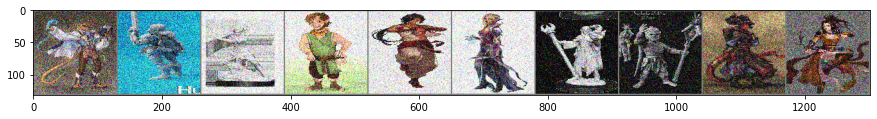

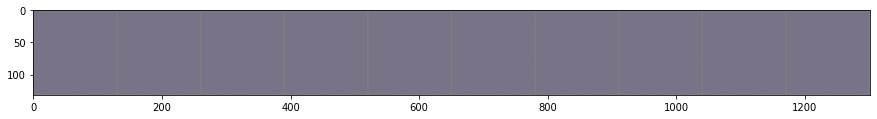

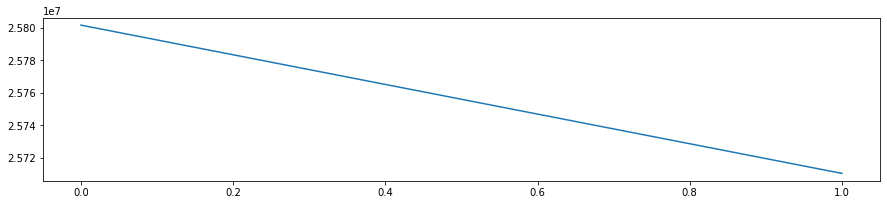

In [ ]:
device = torch.device(0)

batch_size = 1000

imset = ImSet('/home/alan/Projects/gen_dnd_art/posed_images/im128/*pkl')
loader = DataLoader(imset, shuffle=True, batch_size=batch_size)

cvae = ConditionalVariationalAutoEncoder().to(device)
opt = torch.optim.Adam(cvae.parameters())

n_epochs = 1000
best_loss = 9e9
losses = []

model_fname = 'cvae.pth'

for epoch in range(n_epochs):
    counter = 0
    
    for (img_fname, img, species_, class_, gender_) in loader:
        img = img.to(device)
        species_ = species_.to(device)
        class_ = class_.to(device)
        gender_ = gender_.to(device)
        
        Xt = cvae(img, species_, class_, gender_)
        loss = ((img - Xt)**2).sum() + cvae.enc.kl
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        
        sys.stdout.write('\r\t\tepoch=%d, iter=%d, loss=%.2f, kl=%.2f\t\t' % (epoch, counter, loss.item(), cvae.enc.kl))
        
        losses = losses[-1000:]
        
        #if counter % 10 == 0:
        if True:
            # update best loss and save best model
            avg_loss = np.mean(losses[-20:])
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(cvae.state_dict(), model_fname)
            
            clear_output(wait=True)
            
            # show real images
            grid = make_grid(img[:10], nrow=10)
            fig, ax = plt.subplots(figsize=(15, 5))
            show_tensor(grid, ax)
            
            # show encoded images
            grid = make_grid(Xt[:10], nrow=10)
            fig, ax = plt.subplots(figsize=(15, 5))
            show_tensor(grid, ax)
            
            # show fake images
            '''rnd = torch.randn(30, 256).to(device)
            y = torch.LongTensor(list(range(10))*3).to(device)
            z = torch.LongTensor([0]*10 + [1]*10 + [2]*10).to(device)
            fake = cvae.dec(rnd, y, z)
            grid = make_grid(fake[:30], nrow=10)
            
            fig, ax = plt.subplots(figsize=(15, 7))
            show_tensor(grid, ax)'''
            
            # show loss curve
            fig, ax = plt.subplots(figsize=(15, 3))
            ax.plot(losses)
            plt.show()
        
        counter += 1